In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from keras_preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import skimage.exposure
import os



In [2]:
import zipfile
import os

# Define the path to the ZIP file and the directory to extract to
zip_file_path = 'mammography_images.zip'
extract_to_dir = 'directory'

# Create the directory if it doesn't exist
os.makedirs(extract_to_dir, exist_ok=True)

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the directory
    zip_ref.extractall(extract_to_dir)

print(f"Files extracted to {extract_to_dir}")

Files extracted to directory


In [3]:
import pandas as pd

# Replace these paths with the actual paths to your files
train_path = r"content/mammography_images/Training_set.csv"
test_path = r"content/mammography_images/Testing_set.csv"
sub_path = r"content/mammography_images/sample_submission.csv"

# Read the CSV files
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sub = pd.read_csv(sub_path)

# Verify the data
print(train.head())
print(test.head())
print(sub.head())


      filename              label
0  Image_1.jpg     Density3Benign
1  Image_2.jpg     Density1Benign
2  Image_3.jpg  Density1Malignant
3  Image_4.jpg     Density1Benign
4  Image_5.jpg  Density1Malignant
      filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg
      filename           label
0  Image_1.jpg  Density3Benign
1  Image_2.jpg  Density3Benign
2  Image_3.jpg  Density3Benign
3  Image_4.jpg  Density3Benign
4  Image_5.jpg  Density3Benign


In [4]:
train.head()

,filename,label
0,Image_1.jpg,Density3Benign
1,Image_2.jpg,Density1Benign
2,Image_3.jpg,Density1Malignant
3,Image_4.jpg,Density1Benign
4,Image_5.jpg,Density1Malignant


In [5]:
print("len of training set", len(train))
print("len of testing set", len(test))

len of training set 5724
len of testing set 1908


In [6]:

(train["label"].value_counts())

label
Density2Malignant    1728
Density1Malignant    1620
Density3Benign        702
Density1Benign        648
Density3Malignant     432
Density4Benign        324
Density2Benign        216
Density4Malignant      54
Name: count, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Density3Benign'),
  Text(1, 0, 'Density1Benign'),
  Text(2, 0, 'Density1Malignant'),
  Text(3, 0, 'Density4Benign'),
  Text(4, 0, 'Density2Malignant'),
  Text(5, 0, 'Density3Malignant'),
  Text(6, 0, 'Density2Benign'),
  Text(7, 0, 'Density4Malignant')])

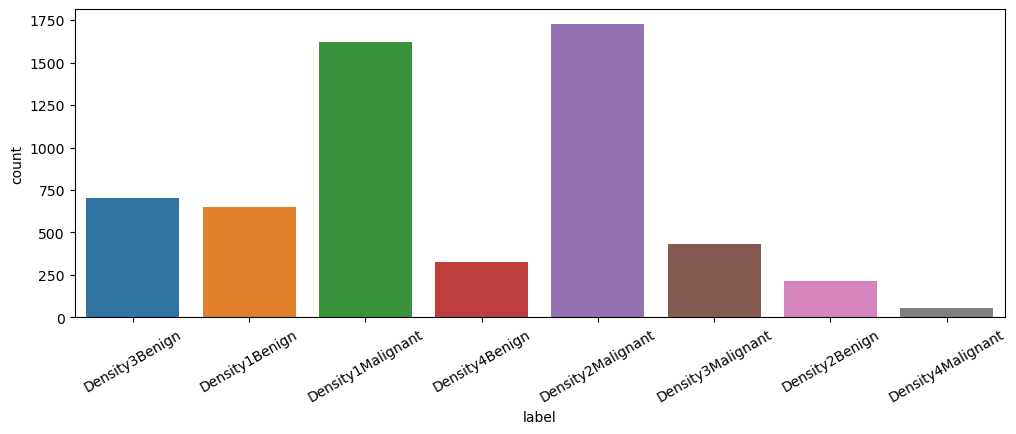

In [7]:
plt.figure(figsize=(12,4))
sns.countplot(x=train["label"],data=train,)
plt.xticks(rotation=30)

In [8]:

train[train["label"]=="Density3Benign"]


,filename,label
0,Image_1.jpg,Density3Benign
6,Image_7.jpg,Density3Benign
19,Image_20.jpg,Density3Benign
24,Image_25.jpg,Density3Benign
33,Image_34.jpg,Density3Benign
...,...,...
5690,Image_5691.jpg,Density3Benign
5705,Image_5706.jpg,Density3Benign
5715,Image_5716.jpg,Density3Benign
5717,Image_5718.jpg,Density3Benign


In [9]:
def preprocess(image):
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    im = cv2.filter2D(image, -1, kernel)
    #out2 = skimage.exposure.rescale_intensity(im, in_range=(150,200), out_range=(0,255))
    out1=(cv2.normalize(im, (224,224),0, 255, cv2.NORM_MINMAX))
    return out1

In [10]:
X_train, X_valid = train_test_split(train, test_size=0.1,stratify=train["label"],shuffle=True)

In [11]:
print("len of training set", len(X_train))
print("len of validation set", len(X_valid))

len of training set 5151
len of validation set 573


In [12]:

datagen=ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess)

In [13]:
train_generator=datagen.flow_from_dataframe(
dataframe=X_train,
directory="content/mammography_images/train",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 5151 validated image filenames belonging to 8 classes.


(224, 224, 3)
(224, 224, 3)


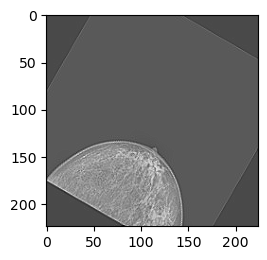

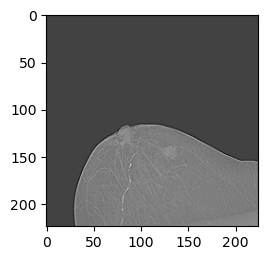

In [14]:
x,y = train_generator.next()
for i in range(2):
    image = x[i]
    plt.figure(figsize=(6,8))
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    print(image.shape)   
plt.show()

In [15]:
valid_datagen=ImageDataGenerator(rescale=1./255.,preprocessing_function=preprocess)
valid_generator=valid_datagen.flow_from_dataframe( 
dataframe=X_valid,
directory="content/mammography_images/train",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))
     

Found 573 validated image filenames belonging to 8 classes.


In [16]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout,AveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3,DenseNet201,EfficientNetB7, MobileNetV2,Xception,VGG16,NASNetMobile
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.models import Sequential
from keras.regularizers import *
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Correct the checkpoint path to end with .weights.h5
checkpoint_path = "training_0/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

my_callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_weights_only=True, save_best_only=True, mode="max"),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min', min_delta=1e-4)
]


In [18]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
     

In [19]:
def build_model():
    model = Sequential()

    conv_base = DenseNet201(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet')
    model.add(conv_base)
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(8, activation='softmax'))

    train_layers = [layer for layer in conv_base.layers[::-1][:5]]

    for layer in conv_base.layers:
        if layer in train_layers:
            layer.trainable = True
    return model

In [20]:
my_model=build_model()
     

In [22]:
my_model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),metrics=["accuracy"],loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1))
     

In [23]:
my_model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=5,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,callbacks=[my_callbacks])
     

Epoch 1/5


C:\Users\91750\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.1916 - loss: 752.9224 
Epoch 1: val_accuracy improved from -inf to 0.21691, saving model to training_0/cp.weights.h5
160/160 ━━━━━━━━━━━━━━━━━━━━ 7011s 43s/step - accuracy: 0.1921 - loss: 752.8362 - val_accuracy: 0.2169 - val_loss: 711.5681 - learning_rate: 1.0000e-05
Epoch 2/5
  1/160 ━━━━━━━━━━━━━━━━━━━━ 2:27:10 56s/step - accuracy: 0.4375 - loss: 711.0588

C:\Users\91750\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.21691
160/160 ━━━━━━━━━━━━━━━━━━━━ 66s 64ms/step - accuracy: 0.4375 - loss: 711.0588 - val_accuracy: 0.2069 - val_loss: 711.2828 - learning_rate: 1.0000e-05
Epoch 3/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 47s/step - accuracy: 0.6115 - loss: 697.0655 
Epoch 3: val_accuracy improved from 0.21691 to 0.32353, saving model to training_0/cp.weights.h5
160/160 ━━━━━━━━━━━━━━━━━━━━ 7541s 47s/step - accuracy: 0.6118 - loss: 696.9822 - val_accuracy: 0.3235 - val_loss: 657.4805 - learning_rate: 1.0000e-05
Epoch 4/5
  1/160 ━━━━━━━━━━━━━━━━━━━━ 1:50:57 42s/step - accuracy: 0.7500 - loss: 656.5269
Epoch 4: val_accuracy did not improve from 0.32353
160/160 ━━━━━━━━━━━━━━━━━━━━ 49s 47ms/step - accuracy: 0.7500 - loss: 656.5269 - val_accuracy: 0.3103 - val_loss: 657.4484 - learning_rate: 1.0000e-05
Epoch 5/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 45s/step - accuracy: 0.8498 - loss: 642.9661 
Epoch 5: val_accuracy improved from 0.32353 to 0.45772, saving model to traini

In [27]:
my_model.load_weights(checkpoint_path)

In [28]:
my_model.evaluate(valid_generator,verbose=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.4590 - loss: 604.4106


[604.4332275390625, 0.452006995677948]

In [29]:
train_generator.class_indices

{'Density1Benign': 0,
 'Density1Malignant': 1,
 'Density2Benign': 2,
 'Density2Malignant': 3,
 'Density3Benign': 4,
 'Density3Malignant': 5,
 'Density4Benign': 6,
 'Density4Malignant': 7}

In [30]:
test_datagen=ImageDataGenerator(rescale=1./255.,preprocessing_function=preprocess)
test_generator=valid_datagen.flow_from_dataframe(
dataframe=test,
directory="content/mammography_images/test",
x_col="filename",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(224,224))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 1908 validated image filenames.


In [31]:
pred1=np.argmax(my_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1),axis=1)

C:\Users\91750\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1908/1908 ━━━━━━━━━━━━━━━━━━━━ 280s 144ms/step


In [32]:

pred1

array([5, 2, 3, ..., 0, 1, 6], dtype=int64)

In [33]:
sub["label"]=pred1
sub["label"]=sub["label"].map({0:'Density1Benign',
 1:'Density1Malignant',
 2:'Density2Benign',
 3:'Density2Malignant',
 4: 'Density3Benign',
 5: 'Density3Malignant',
 6:'Density4Benign',
 7:  'Density4Malignant'})

In [34]:
sub["label"].value_counts()

label
Density1Malignant    610
Density1Benign       339
Density2Benign       286
Density2Malignant    194
Density3Benign       187
Density4Benign       155
Density3Malignant     96
Density4Malignant     41
Name: count, dtype: int64

In [35]:
sub.to_csv("9.csv",index=False)
     